<a href="https://colab.research.google.com/github/sarthakgupta/Deep-Learning-Hands-On/blob/master/GAN_HandsOn_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

import keras
import tensorflow as tf
tf.enable_eager_execution()
# tf.__version__
tf.executing_eagerly()
from tensorflow.keras import layers

from IPython import display

Using TensorFlow backend.


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5 # Normalize the images to [-1, 1]

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=True, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(784, activation=tf.nn.tanh, use_bias=True))
    model.add(layers.Reshape((28, 28, 1)))

    return model


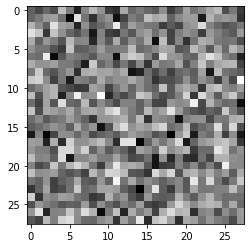

In [6]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(64, activation=tf.nn.tanh, use_bias=True))
    model.add(layers.Dense(1, activation=tf.nn.tanh, use_bias=True))

    return model
    

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.18312119]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    # display.clear_output(wait=True)
    if((epoch+1)%2==0):
      generate_and_save_images(generator, epoch + 1,seed)
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  # fig = plt.figure(figsize=(4,4))
  plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


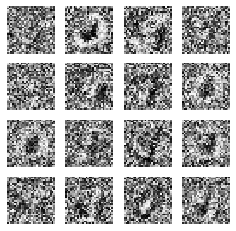

Time for epoch 1 is 20.250101566314697 sec


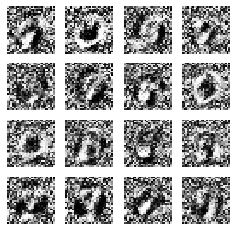

Time for epoch 3 is 15.669572114944458 sec


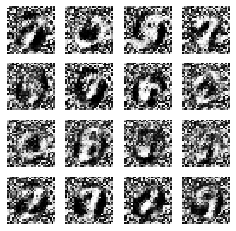

Time for epoch 5 is 15.453506708145142 sec


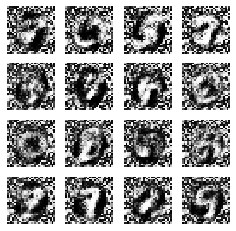

Time for epoch 7 is 15.38038158416748 sec


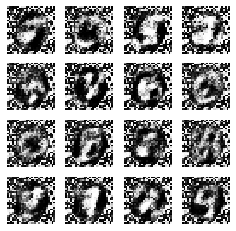

Time for epoch 9 is 15.632132053375244 sec


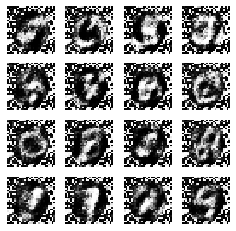

Time for epoch 11 is 15.490946531295776 sec


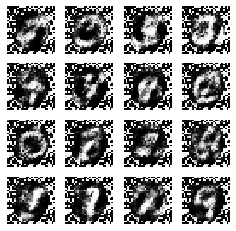

Time for epoch 13 is 15.13296914100647 sec


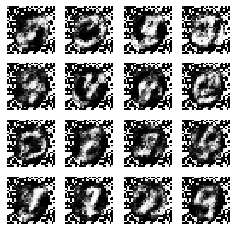

Time for epoch 15 is 15.210262298583984 sec


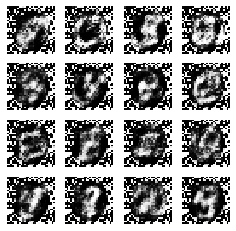

Time for epoch 17 is 15.464050769805908 sec


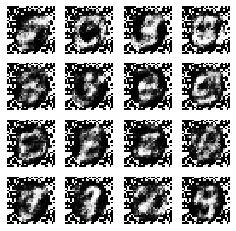

Time for epoch 19 is 15.595936059951782 sec


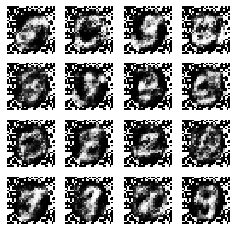

Time for epoch 21 is 15.618292093276978 sec


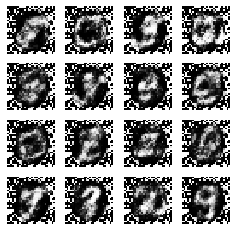

Time for epoch 23 is 15.400734901428223 sec


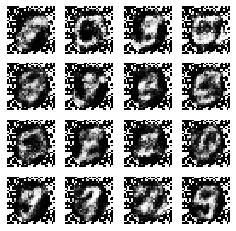

Time for epoch 25 is 15.75077486038208 sec


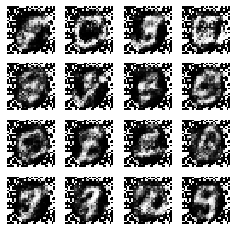

Time for epoch 27 is 15.577955722808838 sec


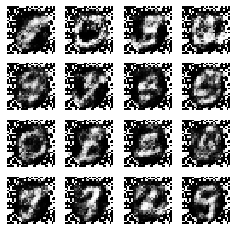

Time for epoch 29 is 15.427054643630981 sec


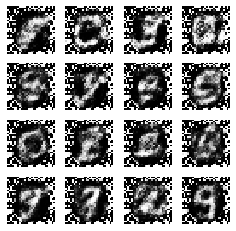

Time for epoch 31 is 15.38780927658081 sec


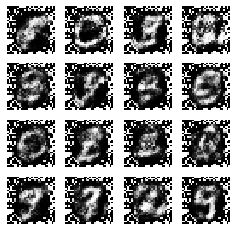

Time for epoch 33 is 15.574930667877197 sec


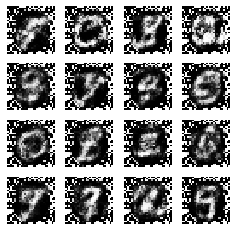

Time for epoch 35 is 15.763575315475464 sec


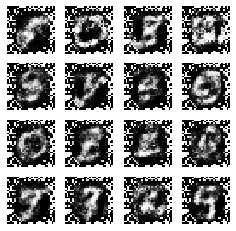

Time for epoch 37 is 15.685132026672363 sec


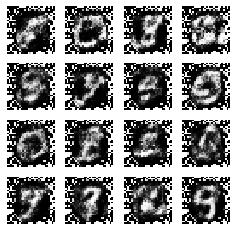

Time for epoch 39 is 15.381813526153564 sec


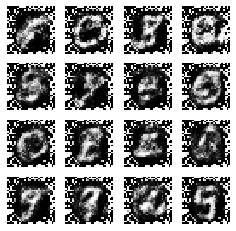

Time for epoch 41 is 15.90696930885315 sec


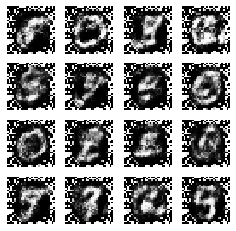

Time for epoch 43 is 15.213486671447754 sec


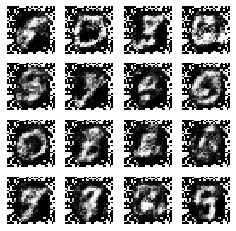

Time for epoch 45 is 14.942638635635376 sec


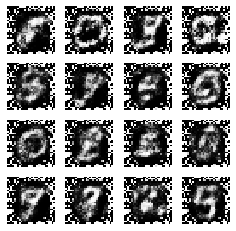

Time for epoch 47 is 15.071814060211182 sec


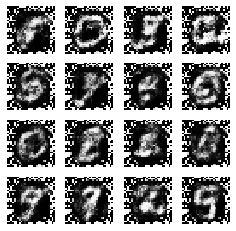

Time for epoch 49 is 15.245473146438599 sec


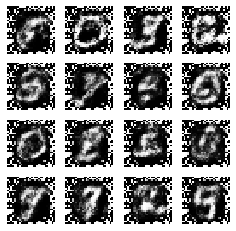

In [15]:
train(train_dataset, EPOCHS)